In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Mini_project_Sem-6

Mounted at /gdrive
/gdrive/My Drive/Mini_project_Sem-6


In [2]:
%ls

AD_Model_Inception_V3.h5              train/
AD_Model_VGG19.h5                     VGG19_Confusion_Matrix.png
Diksha_1918328_miniprojectreport.pdf  VGG19_ct_accuracy.png
Inception.ipynb                       VGG19_dem_loss.png
Inception_V3_Confusion_Matrix.png     VGG19.ipynb
Inception_V3_ct_accuracy.png          VGG19_ROC.png
Inception_V3_dem_loss.png             Weights_AD_Model_Inception_V3.hdf5
Inception_V3_ROC.png                  Weights_AD_Model_VGG19.hdf5
tests/


In [3]:
import numpy as np
!sudo pip3 install keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
IMAGE_SIZE = [229,229]

epochs = 10
batch_size = 4

In [5]:
dement_path = '/gdrive/My Drive/Mini_project_Sem-6/train/mildDemented'
nondement_path = '/gdrive/My Drive/Mini_project_Sem-6/train/nonDemented'

NonDemfiles = glob( nondement_path +'/*' )
Demfiles = glob( dement_path + '/*' )

In [6]:
Dem_labels = []
NonDem_labels = []

Dem_images=[]
NonDem_images=[]

for i in range(len(Demfiles)):
  image = cv2.imread(Demfiles[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(229,229)) 
  Dem_images.append(image) 
  Dem_labels.append('Demented') 
for i in range(len(NonDemfiles)):
  image = cv2.imread(NonDemfiles[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(229,229))
  NonDem_images.append(image)
  NonDem_labels.append('NonDemented')

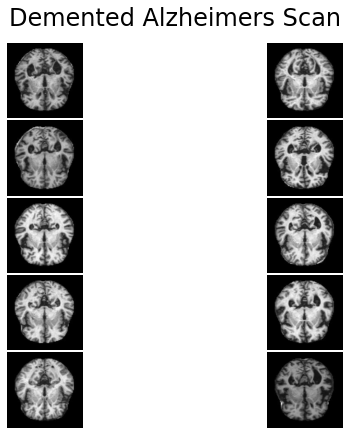

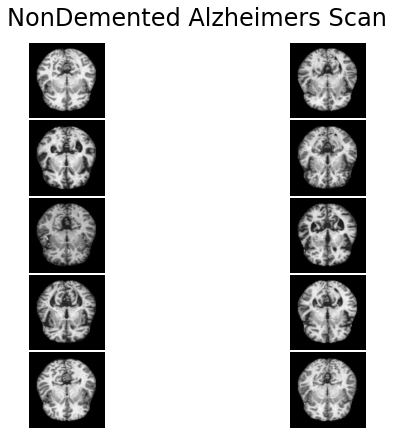

In [7]:
def plot_images(images, title):
    nrows, ncols = 5, 2 
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Dem_images, 'Demented Alzheimers Scan')
plot_images(NonDem_images, 'NonDemented Alzheimers Scan')

In [8]:
Dem_images = np.array(Dem_images) / 255
NonDem_images = np.array(NonDem_images) / 255

In [9]:
Dem_x_train, Dem_x_test, Dem_y_train, Dem_y_test = train_test_split(
    Dem_images, Dem_labels, test_size=0.2)
NonDem_x_train, NonDem_x_test, NonDem_y_train, NonDem_y_test = train_test_split(
    NonDem_images, NonDem_labels, test_size=0.2)


X_train = np.concatenate((NonDem_x_train, Dem_x_train), axis=0)
X_test = np.concatenate((NonDem_x_test, Dem_x_test), axis=0)
y_train = np.concatenate((NonDem_y_train, Dem_y_train), axis=0)
y_test = np.concatenate((NonDem_y_test, Dem_y_test), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [10]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(229, 229, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87924736/87910968 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 114, 114, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 114, 114, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [13]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10
4/4 [==============================] - 8s 989ms/step - loss: 3.2253 - accuracy: 0.5000 - val_loss: 2.4863 - val_accuracy: 0.2500
Epoch 2/10
4/4 [==============================] - 2s 561ms/step - loss: 3.2189 - accuracy: 0.6250 - val_loss: 5.8385 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 5.6642 - accuracy: 0.5000 - val_loss: 5.5562 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 2s 555ms/step - loss: 3.8509 - accuracy: 0.5625 - val_loss: 3.1542 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 2s 554ms/step - loss: 1.8805 - accuracy: 0.6250 - val_loss: 7.4013 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 2s 553ms/step - loss: 1.5416 - accuracy: 0.6875 - val_loss: 5.0438 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 2s 557ms/step - loss: 2.9811 - accuracy: 0.7500 - val_loss: 6.0010 - val_accuracy: 0.5000
Epoch 8/10
4/4 [=======

In [14]:
model.save('AD_Model_Inception_V3.h5')
model.save_weights('Weights_AD_Model_Inception_V3.hdf5')

In [15]:
model = load_model('AD_Model_Inception_V3.h5')

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

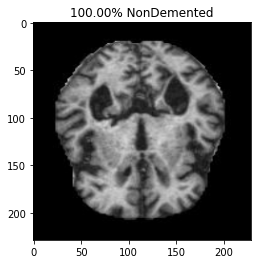

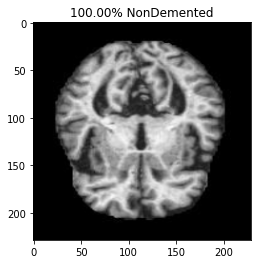

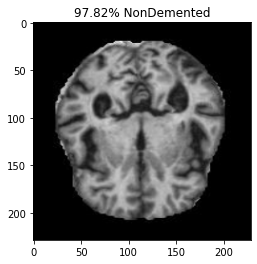

In [ ]:
prediction=y_pred[1:10]
for index, probability in enumerate(prediction):
  if probability.item(0) > 0.5:
        plt.title('%.2f' % (probability.item(0)*100) + '% Demented')
  else:
        plt.title('%.2f' % ((1-probability.item(0))*100) + '% NonDemented')
  plt.style.reload_library
  plt.imshow(Dem_images[index])
  plt.show()

In [17]:
y_pred_bin,y_test_bin=None,None
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

AUC: 0.500


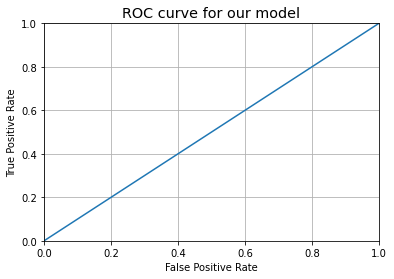

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc = roc_auc_score(y_test_bin, y_pred_bin)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Inception_V3_ROC.png')
plt.grid(True)

Confusion Matrix without Normalization


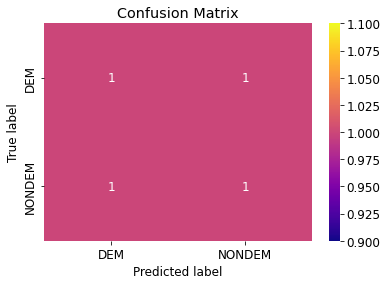

Confusion Matrix with Normalized Values


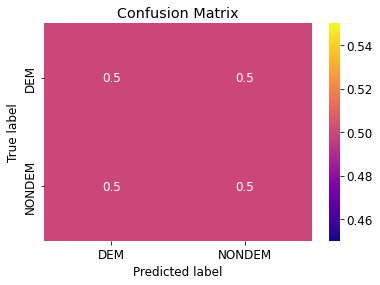

In [19]:
def plot_confusion_matrix(normalize):
  classes = ['DEM','NONDEM']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('Inception_V3_Confusion_Matrix.png')
  plt.show()
 
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
 
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



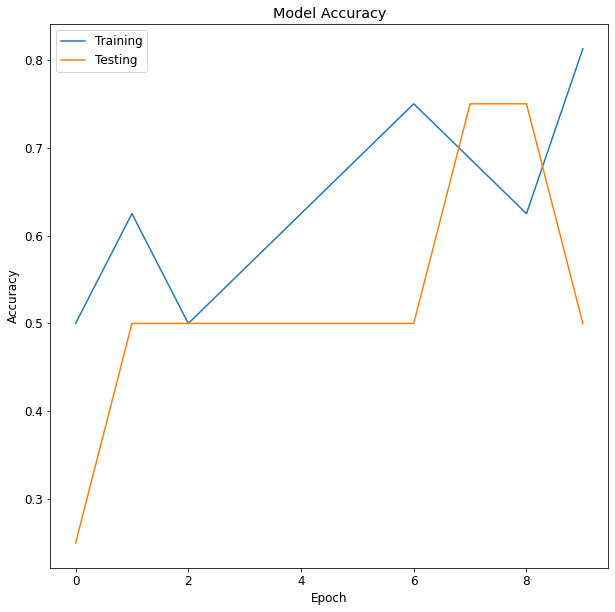

In [21]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('Inception_V3_ct_accuracy.png')
plt.show()

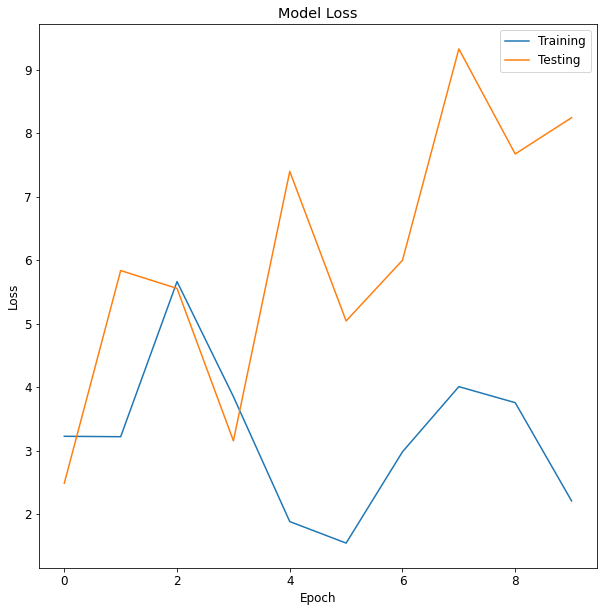

In [22]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('Inception_V3_dem_loss.png')
plt.show()